In [3]:
# importing relevant libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.model_selection import train_test_split
import warnings
import re
import string
warnings.filterwarnings('ignore')

C:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
train_comments = pd.read_csv('train.csv')
test_comments = pd.read_csv('test.csv')

In [19]:
train_comments.iloc[6]

id                                              0002bcb3da6cb337
comment_text        COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
malignant                                                      1
highly_malignant                                               1
rude                                                           1
threat                                                         0
abuse                                                          1
loathe                                                         0
Name: 6, dtype: object

1/1 [==============================] - 0s 119ms/step


In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
x = train_comments['comment_text']
y = train_comments[train_comments.columns[2:]].values

In [7]:
max_features = 200000
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=1800, output_mode='int')

In [8]:
vectorizer.adapt(x.values)
vect_text = vectorizer(x.values)

In [10]:
vect_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32139,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [12]:
train_comments.shape

(159571, 8)

In [16]:
test_comments.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [17]:
dataset = tf.data.Dataset.from_tensor_slices((vect_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [18]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(max_features+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [22]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [24]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 6021s 857ms/step - loss: 0.0617 - val_loss: 0.0453
Epoch 2/10
6981/6981 [==============================] - 5892s 844ms/step - loss: 0.0455 - val_loss: 0.0397
Epoch 3/10
6981/6981 [==============================] - 5908s 846ms/step - loss: 0.0401 - val_loss: 0.0361
Epoch 4/10
6981/6981 [==============================] - 5895s 844ms/step - loss: 0.0362 - val_loss: 0.0310
Epoch 5/10
6981/6981 [==============================] - 5933s 850ms/step - loss: 0.0323 - val_loss: 0.0281
Epoch 6/10
6981/6981 [==============================] - 6278s 899ms/step - loss: 0.0291 - val_loss: 0.0251
Epoch 7/10
6981/6981 [==============================] - 5894s 844ms/step - loss: 0.0261 - val_loss: 0.0223
Epoch 8/10
6981/6981 [==============================] - 5904s 846ms/step - loss: 0.0231 - val_loss: 0.0207
Epoch 9/10
6981/6981 [==============================] - 5880s 842ms/step - loss: 0.0213 - val_loss: 0.0189
Epoch 10/10
6981/6981 [==============

<Figure size 576x360 with 0 Axes>

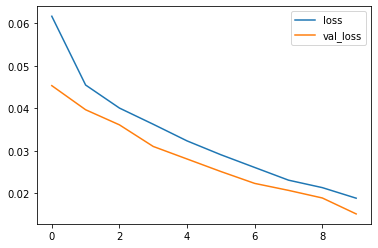

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [58]:
input_text = vectorizer('motherfucker, I will kill you.')
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 120ms/step


In [59]:
(res > 0.5).astype(int)

array([[1, 1, 1, 1, 1, 1]])

1/1 [==============================] - 0s 126ms/step


In [29]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [30]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 423ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
res.shape

(1, 6)

In [32]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 141ms/step
Precision: 0.9400299787521362, Recall:0.9126637578010559, Accuracy:0.505516529083252


In [48]:
model.save('malignant.h5')

In [20]:
test_comments.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [22]:
x_test = test_comments['comment_text']
vect_test = vectorizer(x_test.values)

In [23]:
pred = model.predict(vect_test)

4787/4787 [==============================] - 956s 200ms/step


In [24]:
pred

array([[9.9864244e-01, 2.8548306e-01, 9.9324983e-01, 2.4598069e-02,
        9.3759853e-01, 6.5219544e-02],
       [6.9796348e-12, 0.0000000e+00, 8.5200046e-17, 1.3610435e-35,
        3.8247165e-22, 3.3449129e-20],
       [3.8159254e-05, 7.6231874e-19, 1.2584820e-07, 1.8891591e-14,
        5.2938867e-09, 4.0449137e-09],
       ...,
       [1.1078714e-10, 1.2908916e-37, 2.0596706e-14, 8.9365894e-32,
        1.7845330e-19, 7.9016858e-18],
       [8.3650569e-08, 2.4350375e-28, 5.0765000e-12, 5.8804509e-22,
        1.5416455e-14, 4.3317932e-13],
       [9.9257231e-01, 8.3431753e-04, 8.0213177e-01, 5.7265963e-05,
        6.7748082e-01, 7.9132157e-04]], dtype=float32)

In [51]:
pred_int = (pred >= 0.4).astype(int)
pred_int

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [52]:
df_test = pd.DataFrame()
columns = ['malignant', 'highly_malignan', 'rude', 'threat', 'abuse', 'loathe']

In [53]:
df_test['id'] = test_comments['id']
df_test['comment_text'] = test_comments['comment_text']
df_test[columns] = pred_int

In [54]:
df_test.tail(10)

,id,comment_text,malignant,highly_malignan,rude,threat,abuse,loathe
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,1,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0
153156,fffb5451268fb5ba,""" \n\n == Unicorn lair discovery == \n\n Suppo...",0,0,0,0,0,0
153157,fffc2b34bbe61c8d,:Disagree. Soviet railways need their own arti...,0,0,0,0,0,0
153158,fffc489742ffe69b,This idiot can't even use proper grammar when ...,1,0,0,0,1,0
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0,0,0,0,0,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0,0,0,0,0,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0,0,0,0,0,0
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel...",1,0,1,0,1,0


In [40]:
test_comments.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


1/1 [==============================] - 0s 128ms/step


In [10]:
input_str = vectorizer('hey i freaken hate you!')
res = model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 1s 1s/step


array([[0.66204476, 0.00124213, 0.0446069 , 0.01652899, 0.22366418,
        0.04098011]], dtype=float32)

In [1]:
import gradio as gr

In [9]:
model = tf.keras.models.load_model('malignant.h5')

In [55]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(train_comments.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>=0.4)
    
    return text

In [56]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [57]:
interface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 126ms/step
